# Ofri koren supervised Learning Project

This notebook has two main parts:

1. Regression – predicting a country's GDP using Covid-related and economic data.
2. Classification – predicting customer churn.

I try to go through the usual ML steps: load data, clean it, do a bit of exploration, train a couple of models and compare them, and in the end save the best models with joblib.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import seaborn as sns
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [41]:
uploaded = files.upload()
cov = pd.read_csv("Covid19_With_GDP_Values.csv")
churn = pd.read_csv("customer_churn_dataset.csv")

print(cov.shape, churn.shape)
cov.head()


Saving Covid19_With_GDP_Values.csv to Covid19_With_GDP_Values (1).csv
Saving customer_churn_dataset.csv to customer_churn_dataset (1).csv
(340, 10) (64374, 12)


,Unnamed: 0,Country/Region,Date,Province/State,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,0,Afghanistan,2021-01-01,0,52513.0,2201.0,41727.0,1.426650e+10,11.934,NaN
1,1,Afghanistan,2022-01-01,0,158107.0,7356.0,0.0,1.450216e+10,14.100,NaN
2,2,Albania,2021-01-01,0,58316.0,1181.0,33634.0,1.793057e+10,12.473,123.448662
3,3,Albania,2022-01-01,0,210224.0,3217.0,0.0,1.891638e+10,11.588,131.750835
4,4,Algeria,2021-01-01,0,99897.0,2762.0,67395.0,1.862654e+11,13.607,166.218895


## Regression: Data Prep

Steps:
1) Drop irrelevant columns: Unnamed: 0, Province/State, Date
2) Handle missing values:
   - Drop rows with missing GDP (target)
   - Impute remaining missing numeric/categorical values inside the pipeline (no leakage)
3) Drop duplicates
4) Aggregate to one row per country (mean of numeric columns)


In [42]:
cov_clean = cov.copy()

drop_cols = [c for c in ["Unnamed: 0", "Province/State", "Date"] if c in cov_clean.columns]
cov_clean = cov_clean.drop(columns=drop_cols)

# Drop missing target
cov_clean = cov_clean.dropna(subset=["GDP"])

# Drop duplicates
cov_clean = cov_clean.drop_duplicates()

# Aggregate by country: mean numeric columns
cov_country = cov_clean.groupby("Country/Region").mean(numeric_only=True).reset_index()

print("Countries:", cov_country.shape[0])
cov_country.head()


Countries: 170


,Country/Region,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,Afghanistan,105310.0,4778.5,20863.5,1.438433e+10,13.0170,NaN
1,Albania,134270.0,2199.0,16817.0,1.842347e+10,12.0305,127.599748
2,Algeria,159357.5,4523.0,33697.5,2.059128e+11,13.0220,173.919413
3,Andorra,15928.5,112.0,3731.5,3.352643e+09,12.4370,181.619932
4,Angola,49983.0,1088.5,5573.0,8.545244e+10,15.2460,645.998608


## Regression

I check:
- GDP distribution
- Correlation of numeric features with GDP
- Full correlation heatmap (numeric features)


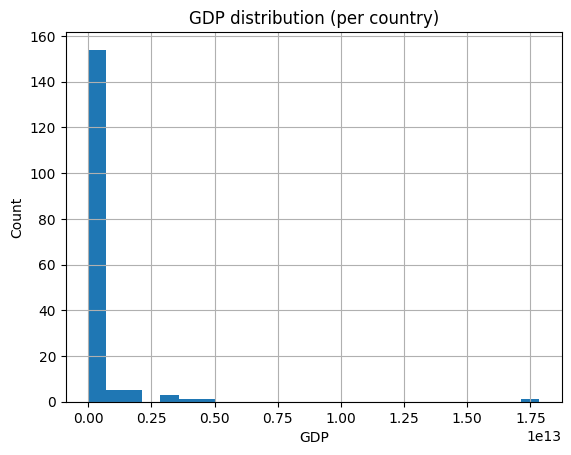

,GDP
GDP,1.000000
Confirmed,0.275122
Deaths,0.243923
Recovered,0.204767
CPI,-0.021508
Unemployment,-0.095645


In [43]:
# GDP distribution
cov_country["GDP"].hist(bins=25)
plt.title("GDP distribution (per country)")
plt.xlabel("GDP")
plt.ylabel("Count")
plt.show()

# Correlations with GDP (numeric only)
num_cols = cov_country.select_dtypes(include=[np.number]).columns
corr_to_gdp = cov_country[num_cols].corr()["GDP"].sort_values(ascending=False)
corr_to_gdp


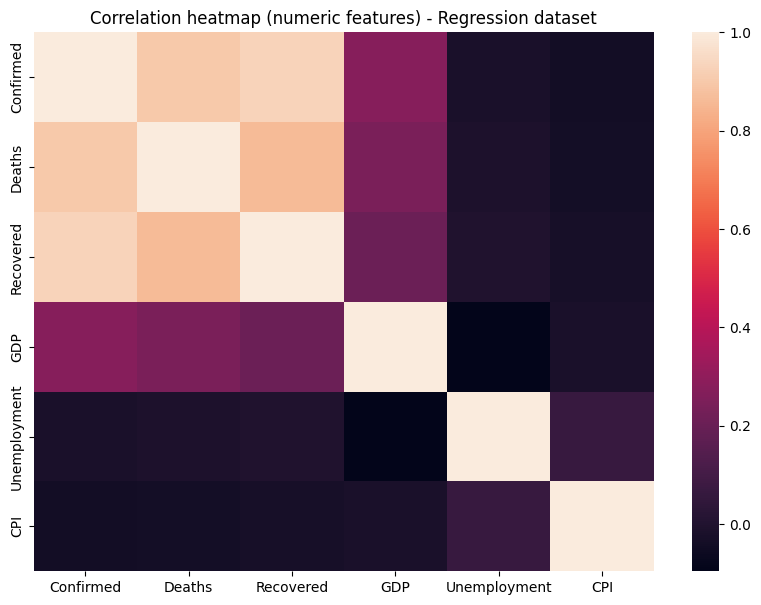

In [44]:
plt.figure(figsize=(10, 7))
sns.heatmap(cov_country[num_cols].corr(), annot=False)
plt.title("Correlation heatmap (numeric features) - Regression dataset")
plt.show()


## notes
- I use the correlation table/heatmap to see which numeric variables move together with GDP.
- Strong correlations can help explain model performance, but correlstion does not mean cause.


## Split and Preprocessing

- Split: 70/30 (test_size=0.3), random_state=42
- Preprocessing is done inside a pipeline:
  - numeric: median imputation + standardization
  - categorical: most_frequent imputation + one-hot encoding
This avoids leakage because preprocessing is fit only on the training set.


In [45]:
y_reg = cov_country["GDP"]
X_reg = cov_country.drop(columns=["GDP"])

numeric_features = X_reg.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_reg.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((119, 6), (51, 6))

In [46]:
def reg_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def evaluate_reg_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    m = reg_metrics(y_test, y_pred)
    m["Model"] = name
    return m


### Model 1: Linear Regression + K-Fold CV

I run K-Fold CV on the training set to estimate stability.


In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", LinearRegression())
])

cv_r2 = cross_val_score(lin_pipe, X_train, y_train, cv=kfold, scoring="r2")
print("Linear Regression CV R2:", cv_r2, "Mean:", cv_r2.mean())

lin_pipe.fit(X_train, y_train)


Linear Regression CV R2: [ -0.03535154 -11.57932857 -14.05329569   0.13764016   0.23068114] Mean: -5.059930899245661


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Confirmed', 'Deaths',
                                                   'Recovered', 'Unemployment',
                                                   'CPI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country/Region'])])),
                ('model', LinearRegression())])

### Model 2: RidgeCV

Ridge regression adds L2 regularization. RidgeCV automatically selects alpha using CV.


In [48]:
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 30)))
])

ridge_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Confirmed', 'Deaths',
                                                   'Recovered', 'Unemployment',
                                                   'CPI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Coun...
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])))])

### Model 3: LassoCV

Lasso adds L1 regularization which can push some coefficients to 0 (feature selection).


In [49]:
lasso_pipe = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", LassoCV(alphas=np.logspace(-3, 1, 30), cv=5, random_state=RANDOM_STATE, max_iter=20000))
])

lasso_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Confirmed', 'Deaths',
                                                   'Recovered', 'Unemployment',
                                                   'CPI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Coun...
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
                         cv=5, max_iter=20000, random_state=42))])

### Model 4: Polyonmial Regression

I use PolynomialFeatures on numeric features (inside pipeline) and tune the degree with GridSearchCV.

In [50]:
# PolynomialFeatures only for numeric columns; keep categorical one-hot as before.
numeric_poly = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False))
])

preprocess_reg_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_poly, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

poly_pipe = Pipeline(steps=[
    ("preprocess", preprocess_reg_poly),
    ("model", LinearRegression())
])

param_grid_poly = {
    "preprocess__num__poly__degree": [1, 2, 3]
}

grid_poly = GridSearchCV(
    poly_pipe, param_grid=param_grid_poly,
    cv=5, scoring="r2", n_jobs=-1
)
grid_poly.fit(X_train, y_train)

print("Best polynomial degree:", grid_poly.best_params_)
best_poly_model = grid_poly.best_estimator_


Best polynomial degree: {'preprocess__num__poly__degree': 1}


## Random Forest Regressor + tuning

I also test Random Forest because it can modrl non-linear relationships.


In [51]:
rf_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocess_reg),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf_reg_pipe, param_grid=param_grid_rf,
    cv=5, scoring="r2", n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
best_rf_reg = grid_rf.best_estimator_


Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}


## Regression: Evaluation and comparison

I compute MAE, MSE, RMSE, R² for each model and plot a single comparison graph (R²).


In [52]:
reg_results = []
reg_results.append(evaluate_reg_model("LinearRegression", lin_pipe, X_test, y_test))
reg_results.append(evaluate_reg_model("RidgeCV", ridge_pipe, X_test, y_test))
reg_results.append(evaluate_reg_model("LassoCV", lasso_pipe, X_test, y_test))
reg_results.append(evaluate_reg_model("Polynomial(best)", best_poly_model, X_test, y_test))
reg_results.append(evaluate_reg_model("RandomForest(best)", best_rf_reg, X_test, y_test))

reg_df = pd.DataFrame(reg_results).sort_values("R2", ascending=False)
reg_df


,MAE,MSE,RMSE,R2,Model
4,1.793685e+11,1.353130e+23,3.678491e+11,0.749866,RandomForest(best)
0,3.026451e+11,1.570547e+23,3.963013e+11,0.709676,LinearRegression
3,3.026451e+11,1.570547e+23,3.963013e+11,0.709676,Polynomial(best)
2,3.268489e+11,2.574561e+23,5.074014e+11,0.524078,LassoCV
1,3.747792e+11,3.088089e+23,5.557057e+11,0.429149,RidgeCV


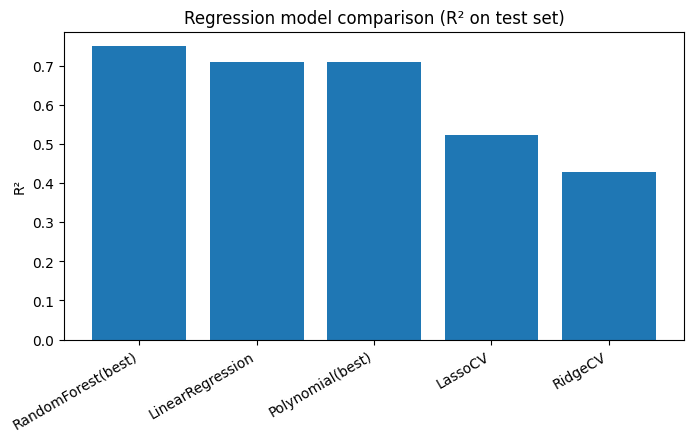

In [53]:
plt.figure(figsize=(8,4))
plt.bar(reg_df["Model"], reg_df["R2"])
plt.xticks(rotation=30, ha="right")
plt.title("Regression model comparison (R² on test set)")
plt.ylabel("R²")
plt.show()


## Regression: Save best model

I save the best model (including preprocessing steps) with joblib and verify load + predict.


In [54]:
best_reg_name = reg_df.iloc[0]["Model"]
best_reg_model = {
    "LinearRegression": lin_pipe,
    "RidgeCV": ridge_pipe,
    "LassoCV": lasso_pipe,
    "Polynomial(best)": best_poly_model,
    "RandomForest(best)": best_rf_reg
}[best_reg_name]

joblib.dump(best_reg_model, "best_regression_model.joblib")
loaded_reg = joblib.load("best_regression_model.joblib")

test_pred = loaded_reg.predict(X_test.iloc[:5])
print("Loaded regression model:", best_reg_name)
print("Sample predictions:", test_pred)


Loaded regression model: RandomForest(best)
Sample predictions: [8.07170407e+10 1.05471101e+10 2.96275093e+11 3.53379349e+11
 1.27674436e+10]


## Classification: Data Prep + Exploration

Steps:
- Drop CustomerID
- Explain missing value handling (impute in pipeline; if you drop, justify why)
- EDA:
  - class balance
  - pairplot of a few numeric features
  - correlation heatmap for numeric features


In [55]:
churn_clean = churn.copy()

if "CustomerID" in churn_clean.columns:
    churn_clean = churn_clean.drop(columns=["CustomerID"])

print("Missing values per column:")
print(churn_clean.isna().sum())

print("\nChurn balance:")
print(churn_clean["Churn"].value_counts(normalize=True))


Missing values per column:
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Churn balance:
Churn
0    0.526315
1    0.473685
Name: proportion, dtype: float64


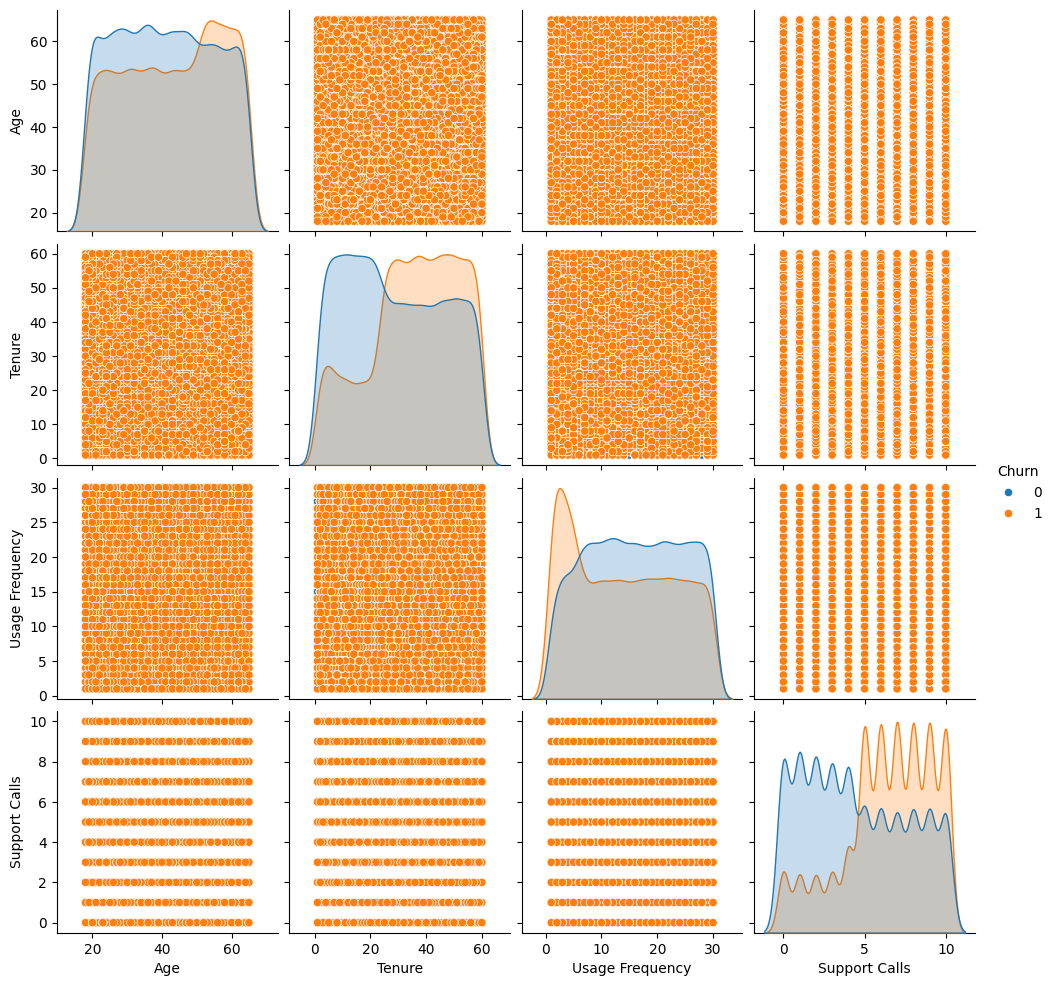

In [56]:
num_cols_ch = churn_clean.select_dtypes(include=[np.number]).columns.tolist()
num_cols_ch = [c for c in num_cols_ch if c != "Churn"]

# take up to 4 numeric cols to keep it readable
pair_cols = num_cols_ch[:4] + ["Churn"]
sns.pairplot(churn_clean[pair_cols], hue="Churn")
plt.show()


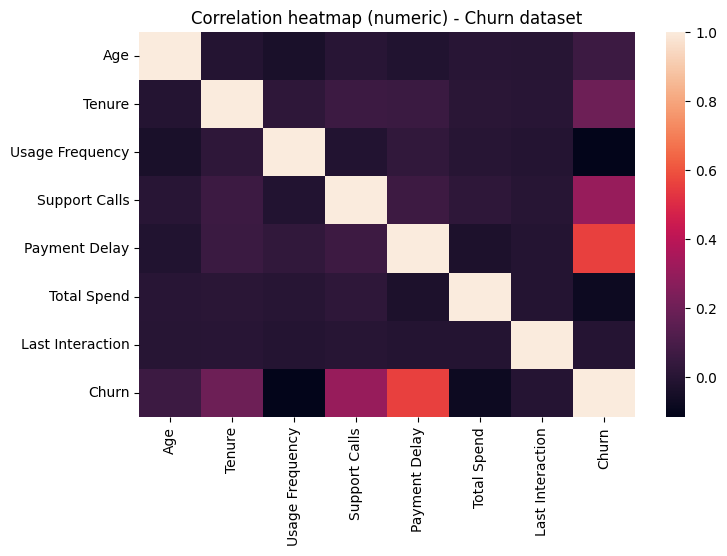

In [57]:
plt.figure(figsize=(8,5))
sns.heatmap(churn_clean[num_cols_ch + ["Churn"]].corr(), annot=False)
plt.title("Correlation heatmap (numeric) - Churn dataset")
plt.show()


### Quick notes (classification EDA)
- I check churn class balance to understand whether the dataset is imbalanced.
- Pairplot and correlation heatmap help show relationships and whether some features may separate churn vs non-churn.


## Classification: Split and Preprocessing

- Split: 70/30 (test_size=0.3), random_state=42
- Preprocessing in pipeline:
  - numeric: median imputation + standardization
  - categorical: most_frequent imputation + one-hot encoding


In [58]:
y_clf = churn_clean["Churn"]
X_clf = churn_clean.drop(columns=["Churn"])

num_features = X_clf.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_clf.select_dtypes(exclude=[np.number]).columns.tolist()

num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_clf = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_features),
        ("cat", cat_tf, cat_features)
    ]
)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=RANDOM_STATE, stratify=y_clf
)

Xc_train.shape, Xc_test.shape


((45061, 10), (19313, 10))

In [59]:
def clf_summary(name, model, X_test, y_test):
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # convert to pseudo-probabilities for display (optional)
        scores = model.decision_function(X_test)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
        "PredLabels": pred,
        "PredProba": proba
    }

def plot_confusion_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [60]:
log_pipe = Pipeline(steps=[
    ("preprocess", preprocess_clf),
    ("model", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

param_log = {
    "model__C": [0.1, 1, 10],
    "model__solver": ["lbfgs"]
}

grid_log = GridSearchCV(log_pipe, param_grid=param_log, cv=5, scoring="f1", n_jobs=-1)
grid_log.fit(Xc_train, yc_train)
best_log = grid_log.best_estimator_

print("Best Logistic params:", grid_log.best_params_)


Best Logistic params: {'model__C': 1, 'model__solver': 'lbfgs'}


In [61]:
knn_pipe = Pipeline(steps=[
    ("preprocess", preprocess_clf),
    ("model", KNeighborsClassifier())
])

param_knn = {
    "model__n_neighbors": [3, 5, 7, 11],
    "model__weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(knn_pipe, param_grid=param_knn, cv=5, scoring="f1", n_jobs=-1)
grid_knn.fit(Xc_train, yc_train)
best_knn = grid_knn.best_estimator_

print("Best KNN params:", grid_knn.best_params_)


Best KNN params: {'model__n_neighbors': 11, 'model__weights': 'distance'}


In [62]:
svm_pipe = Pipeline(steps=[
    ("preprocess", preprocess_clf),
    ("model", SVC(random_state=RANDOM_STATE))  # probability=False
])

param_svm = {
    "model__C": [1],
    "model__kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    svm_pipe, param_grid=param_svm, cv=5, scoring="f1", n_jobs=-1
)
grid_svm.fit(Xc_train, yc_train)
best_svm = grid_svm.best_estimator_


In [63]:
rf_clf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_clf),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE))
])

param_rf_clf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

grid_rf_clf = GridSearchCV(rf_clf_pipe, param_grid=param_rf_clf, cv=5, scoring="f1", n_jobs=-1)
grid_rf_clf.fit(Xc_train, yc_train)
best_rf_clf = grid_rf_clf.best_estimator_

print("Best RF params:", grid_rf_clf.best_params_)


Best RF params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 500}


## Classification: Evaluation

I report:
- Accuracy, Precision, Recall, F1
- Confusion matrix as a heatmap
- Class probabilities (first few rows)
- Comparison dataframe across models


In [64]:
clf_models = {
    "Logistic(best)": best_log,
    "KNN(best)": best_knn,
    "SVM(best)": best_svm,
    "RandomForest(best)": best_rf_clf
}

clf_rows = []
pred_store = {}

for name, mdl in clf_models.items():
    out = clf_summary(name, mdl, Xc_test, yc_test)
    clf_rows.append({k: out[k] for k in ["Model", "Accuracy", "Precision", "Recall", "F1"]})
    pred_store[name] = out

clf_df = pd.DataFrame(clf_rows).sort_values("F1", ascending=False)
clf_df


,Model,Accuracy,Precision,Recall,F1
3,RandomForest(best),0.998395,0.999343,0.997267,0.998304
2,SVM(best),0.944442,0.926572,0.958679,0.942352
1,KNN(best),0.915497,0.881755,0.948841,0.914069
0,Logistic(best),0.827474,0.813160,0.825426,0.819247


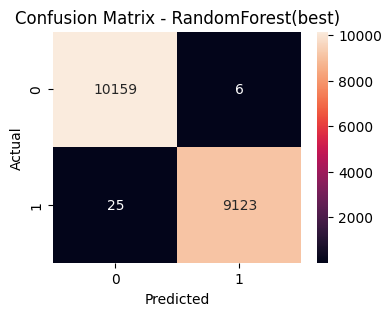

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10165
           1       1.00      1.00      1.00      9148

    accuracy                           1.00     19313
   macro avg       1.00      1.00      1.00     19313
weighted avg       1.00      1.00      1.00     19313



In [65]:
best_clf_name = clf_df.iloc[0]["Model"]
best_clf = clf_models[best_clf_name]

y_pred_best = best_clf.predict(Xc_test)
plot_confusion_heatmap(yc_test, y_pred_best, f"Confusion Matrix - {best_clf_name}")
print(classification_report(yc_test, y_pred_best))


In [66]:
# show probabilities for first 10 samples (required "class probabilities")
proba = pred_store[best_clf_name]["PredProba"]
print("First 10 predicted probabilities for class=1 (churn):")
print(proba[:10])


First 10 predicted probabilities for class=1 (churn):
[0.12640794 0.97148571 0.97552857 0.01554935 0.508386   0.96408333
 0.03818333 0.9779     0.91123651 0.01765714]


## Classification: Save best model

I save the best model (including preprocessing pipeline) and verify that loading works.


In [67]:
joblib.dump(best_clf, "best_classification_model.joblib")
loaded_clf = joblib.load("best_classification_model.joblib")

pred_check = loaded_clf.predict(Xc_test.iloc[:5])
print("Loaded classifier:", best_clf_name)
print("Sample predictions:", pred_check)


Loaded classifier: RandomForest(best)
Sample predictions: [0 1 1 0 1]


### I didnt have so much fun making this project, ive missed alot of classes lately due to a new job but it doesnt change the fact that im a bit behind on the meterial and this project really showed me that

In [68]:
!python -V


Python 3.12.12


In [69]:
import numpy as np
import sklearn
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)


numpy: 2.0.2
sklearn: 1.6.1


In [70]:
print(cov.shape)
print(churn.shape)
display(cov.head(3))
display(churn.head(3))


(340, 10)
(64374, 12)


,Unnamed: 0,Country/Region,Date,Province/State,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,0,Afghanistan,2021-01-01,0,52513.0,2201.0,41727.0,1.426650e+10,11.934,NaN
1,1,Afghanistan,2022-01-01,0,158107.0,7356.0,0.0,1.450216e+10,14.100,NaN
2,2,Albania,2021-01-01,0,58316.0,1181.0,33634.0,1.793057e+10,12.473,123.448662


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0


In [71]:
print(cov_country.shape)
cov_country.head(3)


(170, 7)


,Country/Region,Confirmed,Deaths,Recovered,GDP,Unemployment,CPI
0,Afghanistan,105310.0,4778.5,20863.5,1.438433e+10,13.0170,NaN
1,Albania,134270.0,2199.0,16817.0,1.842347e+10,12.0305,127.599748
2,Algeria,159357.5,4523.0,33697.5,2.059128e+11,13.0220,173.919413


In [72]:
print(churn_clean.shape)
churn_clean.head(3)


(64374, 11)


,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,47,Male,27,10,2,29,Premium,Annual,757,21,0


In [73]:
print(X_train.shape, X_test.shape)


(119, 6) (51, 6)


In [74]:
print(Xc_train.shape, Xc_test.shape)


(45061, 10) (19313, 10)


In [75]:
Xt = preprocess_clf.fit_transform(Xc_train)
Xs = preprocess_clf.transform(Xc_test)
print(Xt.shape, Xs.shape)


(45061, 15) (19313, 15)


In [76]:
print(type(lin_pipe), type(ridge_pipe), type(lasso_pipe), type(best_poly_model))



<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>


In [77]:
print(type(best_log), type(best_knn), type(best_svm), type(best_rf_clf))


<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>


In [78]:
display(reg_df)


,MAE,MSE,RMSE,R2,Model
4,1.793685e+11,1.353130e+23,3.678491e+11,0.749866,RandomForest(best)
0,3.026451e+11,1.570547e+23,3.963013e+11,0.709676,LinearRegression
3,3.026451e+11,1.570547e+23,3.963013e+11,0.709676,Polynomial(best)
2,3.268489e+11,2.574561e+23,5.074014e+11,0.524078,LassoCV
1,3.747792e+11,3.088089e+23,5.557057e+11,0.429149,RidgeCV


In [79]:
display(clf_df)


,Model,Accuracy,Precision,Recall,F1
3,RandomForest(best),0.998395,0.999343,0.997267,0.998304
2,SVM(best),0.944442,0.926572,0.958679,0.942352
1,KNN(best),0.915497,0.881755,0.948841,0.914069
0,Logistic(best),0.827474,0.813160,0.825426,0.819247


In [80]:
import joblib
loaded_reg = joblib.load("best_regression_model.joblib")
print("Loaded reg model ok:", loaded_reg.predict(X_test.iloc[:3]))


Loaded reg model ok: [8.07170407e+10 1.05471101e+10 2.96275093e+11]


In [81]:
loaded_clf = joblib.load("best_classification_model.joblib")
print("Loaded clf model ok:", loaded_clf.predict(Xc_test.iloc[:3]))


Loaded clf model ok: [0 1 1]
